# Import Libraries, EDA & Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from pathlib import Path
import cv2
import time
import random
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from keras import utils
from torchvision import datasets, transforms
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

All Libraries Imported Successfully


In [2]:
data_dir = "/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification"


train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)


validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [3]:
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [4]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [5]:
x_train = []
y_train = []

for images, labels in train_dataset:

    x_train.append(images.numpy())

    y_train.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [6]:
x_train

array([[[[0.6443244 , 0.6443244 , 0.6443244 ],
         [0.6205499 , 0.6205499 , 0.6205499 ],
         [0.586314  , 0.586314  , 0.586314  ],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.654902  , 0.654902  , 0.654902  ],
         [0.6366461 , 0.6366461 , 0.6366461 ],
         [0.6071308 , 0.6071308 , 0.6071308 ],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.6516008 , 0.6516008 , 0.6516008 ],
         [0.63936514, 0.63936514, 0.63936514],
         [0.6139384 , 0.6139384 , 0.6139384 ],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.6997233 , 0.6997233 , 0.6997233 ],
         [0.6992255 , 0.6992255 , 0.6992255 ]

In [7]:
y_train

array([4, 2, 2, ..., 1, 1, 0], dtype=int32)

In [8]:
x_val = []
y_val = []

for images, labels in val_dataset:

    x_val.append(images.numpy())

    y_val.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [9]:
x_val

array([[[[0.9676471 , 0.9676471 , 0.9676471 ],
         [0.9821078 , 0.9821078 , 0.9821078 ],
         [0.9973039 , 0.9973039 , 0.9973039 ],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99509805, 0.99509805, 0.99509805],
         [0.9970588 , 0.9970588 , 0.9970588 ]],

        [[0.9882353 , 0.9882353 , 0.9882353 ],
         [0.985049  , 0.985049  , 0.985049  ],
         [0.9855392 , 0.9855392 , 0.9855392 ],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99509805, 0.99509805, 0.99509805],
         [0.9970588 , 0.9970588 , 0.9970588 ]],

        [[1.        , 1.        , 1.        ],
         [0.9909314 , 0.9909314 , 0.9909314 ],
         [0.9786765 , 0.9786765 , 0.9786765 ],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.99509805, 0.99509805, 0.99509805],
         [0.9970588 , 0.9970588 , 0.9970588 ]],

        ...,

        [[0.9911765 , 0.9911765 , 0.9911765 ],
         [0.99191177, 0.99191177, 0.99191177]

In [10]:
y_val

array([9, 2, 9, 7, 8, 9, 2, 4, 6, 4, 7, 0, 1, 3, 4, 3, 5, 7, 0, 0, 1, 8,
       6, 5, 2, 2, 6, 6, 2, 3, 6, 6, 5, 6, 1, 0, 7, 1, 8, 0, 5, 2, 3, 2,
       7, 6, 1, 8, 8, 2, 1, 6, 3, 1, 0, 4, 2, 0, 7, 2, 8, 6, 8, 1, 2, 1,
       9, 2, 0, 8, 9, 7, 4, 2, 3, 1, 3, 7, 4, 0, 1, 2, 6, 5, 3, 6, 1, 8,
       1, 9, 2, 5, 0, 4, 8, 5, 9, 8, 4, 4, 1, 2, 5, 0, 8, 3, 7, 4, 3, 1,
       7, 2], dtype=int32)

In [11]:
def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [12]:
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

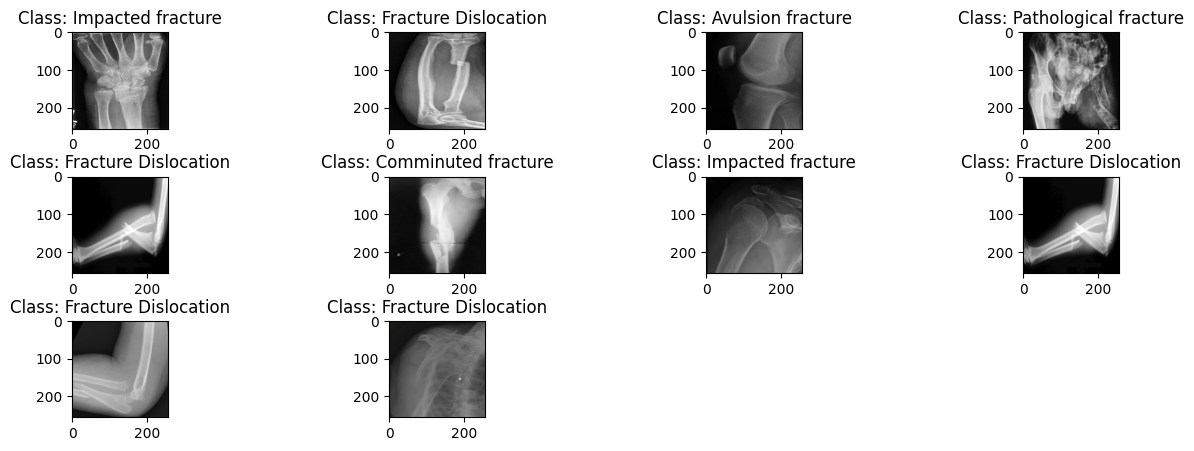

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
images = x_train[:100]
n = 10
size = (15, 5)
cmap = "gray_r"
as_type = "float32"


# Randomly select indices
indices = np.random.choice(len(images), n)

num_images_per_row = 4
num_rows = (n + num_images_per_row - 1) // num_images_per_row

# Set up the subplots
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=size)

for i, ax in enumerate(axes.flat):
    if i < len(indices):
        index = indices[i]
        label_index = y_train[index]
        
        # Convert integer label to class name
        class_name = class_names_dict.get(label_index, f'Unknown Class {label_index}')
        
        # Display the image and label
        ax.imshow(images[index].astype(as_type), cmap=cmap)
        ax.set_title(f'Class: {class_name}')
    else:
        # Hide unused subplots
        ax.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1017, 256, 256, 3), (1017,), (112, 256, 256, 3), (112,))

In [15]:
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

# VGG16

In [122]:
vgg16 = VGG16(input_shape=(256,256,3), weights='imagenet', include_top=False)

In [123]:
for layer in vgg16.layers:
    layer.trainable = False

In [124]:
flat = Flatten()(vgg16.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(flat)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

output = Dense(10, activation='softmax')(act5)

In [125]:
final_vgg16 = Model(inputs=vgg16.input,outputs=output)

In [126]:
final_vgg16.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        33,02

 Total params: 16,895,050 (64.45 MB)

 Trainable params: 2,180,362 (8.32 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [127]:
final_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
from tensorflow.keras.utils import to_categorical


# Confirm the shapes are now correct
print("y_train shape:", y_train.shape)  # Expected: (1017, 10)
print("y_val shape:", y_val.shape)      # Expected: (112, 10)


y_train shape: (1017, 10)
y_val shape: (112, 10)


In [129]:
history = final_vgg16.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)


Epoch 1/16


I0000 00:00:1730820693.129111     133 service.cc:145] XLA service 0x7af44c006f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730820693.129186     133 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730820693.129193     133 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/32 ━━━━━━━━━━━━━━━━━━━━ 9:06 18s/step - accuracy: 0.0938 - loss: 2.5045

I0000 00:00:1730820708.570546     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 596ms/step - accuracy: 0.1088 - loss: 2.6154
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.2476 - loss: 2.1302
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.2771 - loss: 2.0566
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.3317 - loss: 1.8710
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.4918 - loss: 1.4966
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.5493 - loss: 1.2839
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.6162 - loss: 1.0561
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7085 - loss: 0.8388
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.7453 - loss: 0.7292
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7969 - loss: 0.5576
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7881 - loss: 0.5539
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accurac

In [130]:
train_loss, train_accuracy = final_vgg16.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_vgg16.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 92.33%
Test Accuracy: 84.82%


In [131]:
CLASSES = np.array(class_names)

preds = final_vgg16.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


In [133]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [136]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

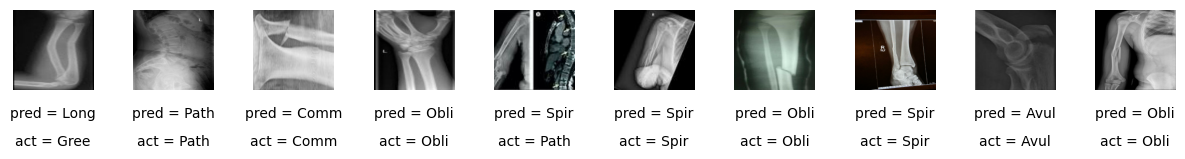

In [137]:
display_preds_act(n=10)

In [138]:
final_vgg16.save("BreakBone_VGG16.h5")

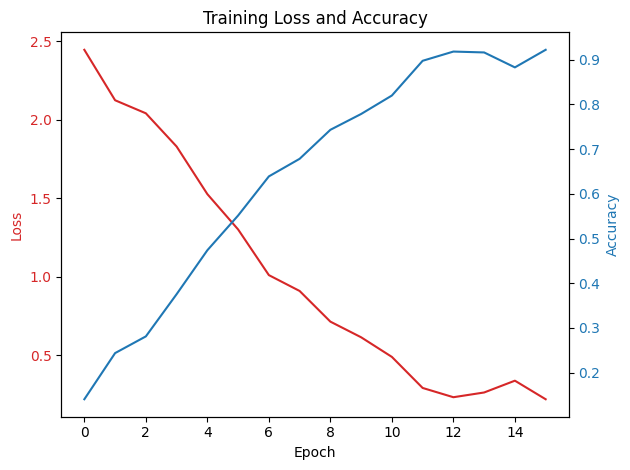

In [143]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


In [154]:
y_pred = final_vgg16.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       1.00      0.82      0.90        11
  Comminuted fracture       0.91      0.67      0.77        15
 Fracture Dislocation       0.81      1.00      0.89        17
  Greenstick fracture       0.80      0.80      0.80        10
    Hairline Fracture       0.86      0.60      0.71        10
    Impacted fracture       0.86      0.75      0.80         8
Longitudinal fracture       0.92      0.92      0.92        12
     Oblique fracture       0.67      1.00      0.80        10
Pathological fracture       0.92      0.92      0.92        12
      Spiral Fracture       0.88      1.00      0.93         7

             accuracy                           0.85       112
            macro avg       0.86      0.85      0.84       112
         weighted avg       0.86      0.85      0.85       112



In [155]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [1.         0.90909091 0.80952381 0.8        0.85714286 0.85714286
 0.91666667 0.66666667 0.91666667 0.875     ]
Recall per class: [0.81818182 0.66666667 1.         0.8        0.6        0.75
 0.91666667 1.         0.91666667 1.        ]
F1 Score per class: [0.9        0.76923077 0.89473684 0.8        0.70588235 0.8
 0.91666667 0.8        0.91666667 0.93333333]
Specificity per class: [1.0, 0.9896907216494846, 0.9578947368421052, 0.9803921568627451, 0.9901960784313726, 0.9903846153846154, 0.99, 0.9509803921568627, 0.99, 0.9904761904761905]
Cohen's Kappa Score: 0.8300455235204856
Matthews Correlation Coefficient (MCC): 0.832727023962102


In [156]:
print(conf_matrix)

[[ 9  0  0  0  1  1  0  0  0  0]
 [ 0 10  0  2  0  0  0  3  0  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  1  1  0  0]
 [ 0  0  3  0  6  0  0  0  1  0]
 [ 0  0  1  0  0  6  0  1  0  0]
 [ 0  1  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 11  1]
 [ 0  0  0  0  0  0  0  0  0  7]]


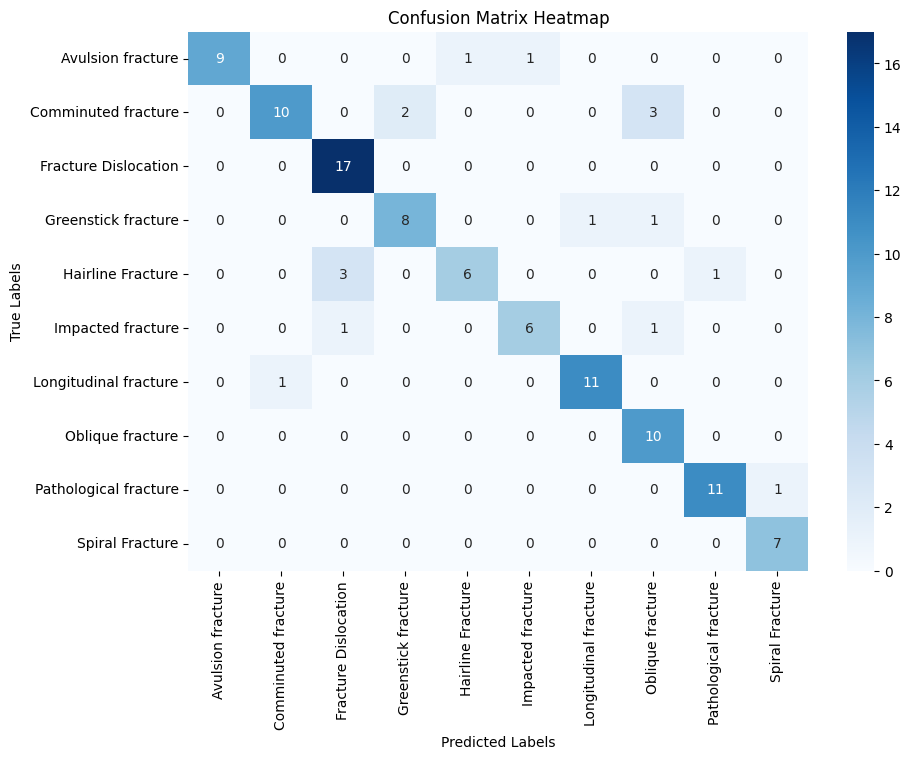

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names_dict.values()),
            yticklabels=list(class_names_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


# VGG 19

In [22]:
vgg19 = VGG19(input_shape=(256,256,3), weights='imagenet', include_top=False)

In [23]:
x = Flatten()(vgg19.output)


dense1 = Dense(128, kernel_initializer='he_uniform')(x)
bn1 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn1)
drop1 = Dropout(0.5)(act1)

dense2 = Dense(256, kernel_initializer='he_uniform')(drop1)
bn2 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn2)
drop2 = Dropout(0.5)(act2)

dense3 = Dense(512, kernel_initializer='he_uniform')(drop2)
bn3 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn3)
drop3 = Dropout(0.5)(act3)

dense4 = Dense(256, kernel_initializer='he_uniform')(drop3)
bn4 = BatchNormalization()(dense4)
act4 = Activation('relu')(bn4)
drop4 = Dropout(0.5)(act4)

dense5 = Dense(128, kernel_initializer='he_uniform')(drop4)
bn5 = BatchNormalization()(dense5)
act5 = Activation('relu')(bn5)
drop5 = Dropout(0.5)(act5)

# Output layer with softmax activation for multi-class classification
predictions = Dense(10, activation='softmax')(drop5)

# Combine with the base model
model = Model(inputs=vgg19.input, outputs=predictions)


In [24]:
final_vgg19 = Model(inputs=vgg19.input, outputs=predictions)

In [25]:
final_vgg19.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           51

 Total params: 24,554,058 (93.67 MB)

 Trainable params: 24,551,498 (93.66 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [26]:
final_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = final_vgg19.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)


Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 917ms/step - accuracy: 0.0909 - loss: 2.9808
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step - accuracy: 0.1133 - loss: 2.7866
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.0984 - loss: 2.7744
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.1171 - loss: 2.6021
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 582ms/step - accuracy: 0.1093 - loss: 2.6967
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.0895 - loss: 2.6986
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.1354 - loss: 2.5839
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 586ms/step - accuracy: 0.1364 - loss: 2.5017
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.1249 - loss: 2.5087
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.1018 - loss: 2.5075
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.1091 - loss: 2.4548
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19

In [28]:
train_loss, train_accuracy = final_vgg19.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_vgg19.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 15.83%
Test Accuracy: 15.18%


In [30]:
CLASSES = np.array(class_names)

preds = final_vgg19.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step


In [31]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [32]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

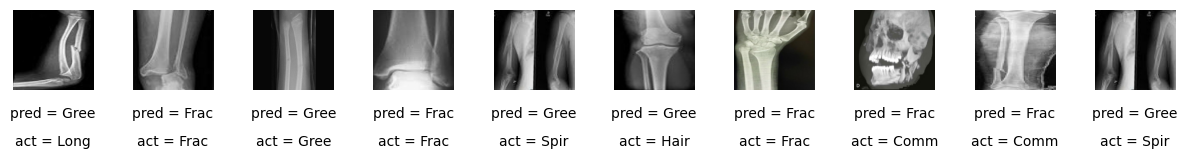

In [35]:
display_preds_act(n=10)

In [36]:
final_vgg19.save("BreakBone_VGG19.h5")

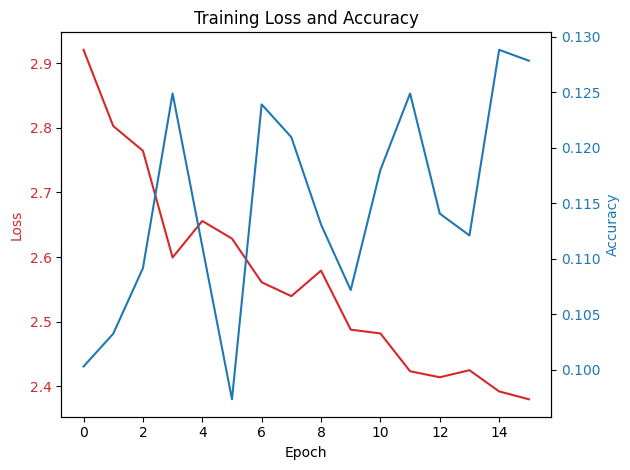

In [37]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


In [39]:
y_pred = final_vgg19.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.00      0.00      0.00        11
  Comminuted fracture       0.00      0.00      0.00        15
 Fracture Dislocation       0.31      0.59      0.41        17
  Greenstick fracture       0.09      0.70      0.16        10
    Hairline Fracture       0.00      0.00      0.00        10
    Impacted fracture       0.00      0.00      0.00         8
Longitudinal fracture       0.00      0.00      0.00        12
     Oblique fracture       0.00      0.00      0.00        10
Pathological fracture       0.00      0.00      0.00        12
      Spiral Fracture       0.00      0.00      0.00         7

             accuracy                           0.15       112
            macro avg       0.04      0.13      0.06       112
         weighted avg       0.06      0.15      0.08       112



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.         0.         0.3125     0.09333333 0.         0.
 0.         0.         0.         0.        ]
Recall per class: [0.         0.         0.58823529 0.7        0.         0.
 0.         0.         0.         0.        ]
F1 Score per class: [0.         0.         0.40816327 0.16470588 0.         0.
 0.         0.         0.         0.        ]
Specificity per class: [1.0, 0.9896907216494846, 0.7684210526315789, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9619047619047619]
Cohen's Kappa Score: 0.05059337913803885
Matthews Correlation Coefficient (MCC): 0.06985607927574258


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


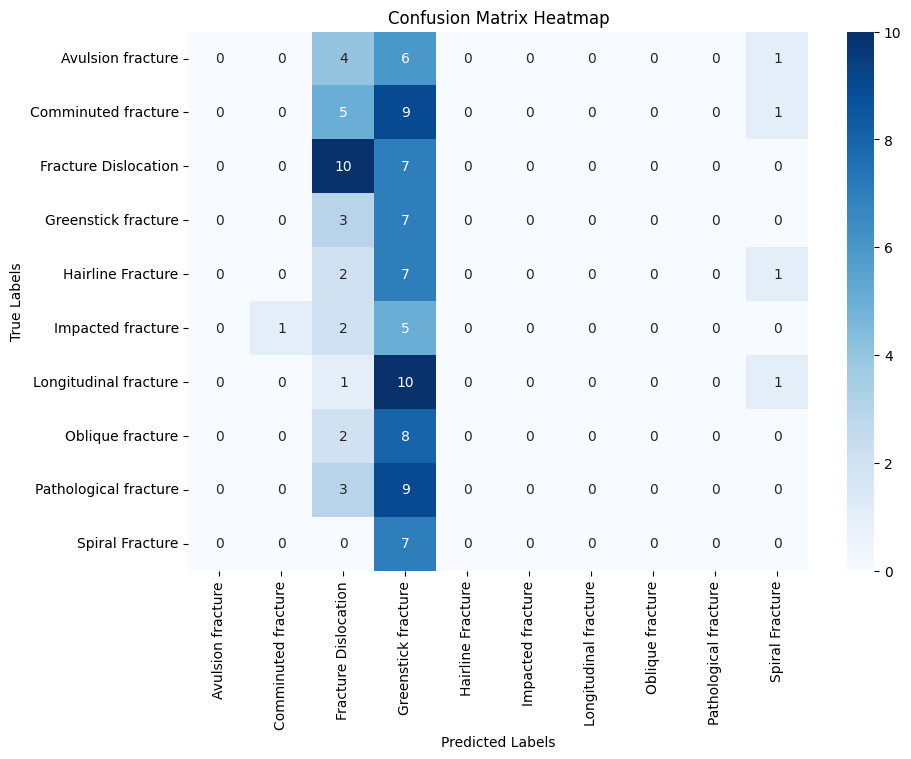

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names_dict.values()),
            yticklabels=list(class_names_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


# ResNet 50

In [51]:
resnet50 = ResNet50(input_shape=(256,256,3), weights='imagenet', include_top=False)

In [60]:
x = Flatten()(resnet50.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(x)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

output = Dense(10, activation='softmax')(act5)

In [61]:
final_resnet50 = Model(inputs=resnet50.input, outputs=predictions)

In [62]:
final_resnet50.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 32,059,786 (122.30 MB)

 Trainable params: 32,006,538 (122.10 MB)

 Non-trainable params: 53,248 (208.00 KB)

In [63]:
final_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
history = final_resnet50.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)


Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.7635 - loss: 0.7003
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - accuracy: 0.8089 - loss: 0.5909
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - accuracy: 0.8875 - loss: 0.3497
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.8896 - loss: 0.3324
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.9438 - loss: 0.2166
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.8833 - loss: 0.3807
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.9174 - loss: 0.3375
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.9298 - loss: 0.2276
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.9112 - loss: 0.2952
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.9556 - loss: 0.1492
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.9520 - loss: 0.1465
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 20

In [67]:
train_loss, train_accuracy = final_resnet50.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_resnet50.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 85.74%
Test Accuracy: 83.93%


In [68]:
CLASSES = np.array(class_names)

preds = final_resnet50.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  


In [69]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [70]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

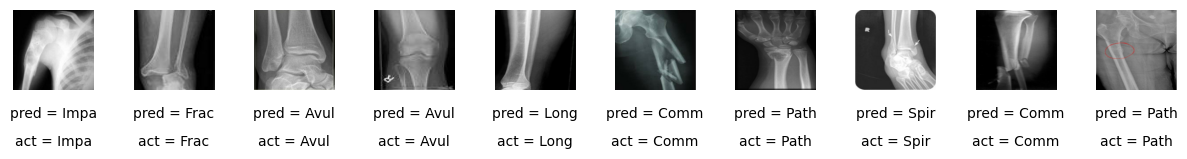

In [71]:
display_preds_act(n=10)

In [72]:
final_resnet50.save("BreakBone_Resnet50.h5")

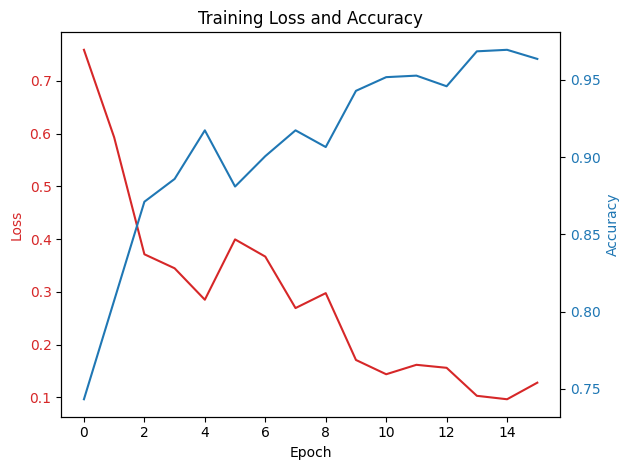

In [73]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


In [74]:
y_pred = final_resnet50.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       1.00      0.91      0.95        11
  Comminuted fracture       1.00      0.87      0.93        15
 Fracture Dislocation       0.92      0.65      0.76        17
  Greenstick fracture       0.80      0.80      0.80        10
    Hairline Fracture       0.71      1.00      0.83        10
    Impacted fracture       0.67      0.75      0.71         8
Longitudinal fracture       0.79      0.92      0.85        12
     Oblique fracture       0.75      0.60      0.67        10
Pathological fracture       0.86      1.00      0.92        12
      Spiral Fracture       0.88      1.00      0.93         7

             accuracy                           0.84       112
            macro avg       0.84      0.85      0.83       112
         weighted avg       0.85      0.84      0.84       112



In [75]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [1.         1.         0.91666667 0.8        0.71428571 0.66666667
 0.78571429 0.75       0.85714286 0.875     ]
Recall per class: [0.90909091 0.86666667 0.64705882 0.8        1.         0.75
 0.91666667 0.6        1.         1.        ]
F1 Score per class: [0.95238095 0.92857143 0.75862069 0.8        0.83333333 0.70588235
 0.84615385 0.66666667 0.92307692 0.93333333]
Specificity per class: [1.0, 1.0, 0.9894736842105263, 0.9803921568627451, 0.9607843137254902, 0.9711538461538461, 0.97, 0.9803921568627451, 0.98, 0.9904761904761905]
Cohen's Kappa Score: 0.8208159274731135
Matthews Correlation Coefficient (MCC): 0.8230109792090983


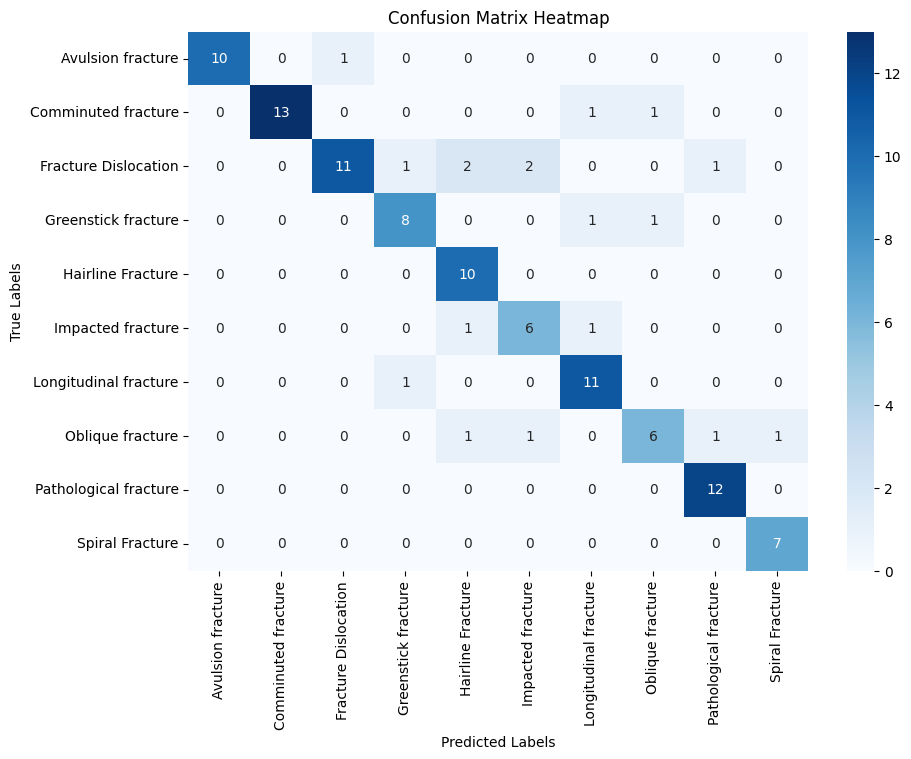

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names_dict.values()),
            yticklabels=list(class_names_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


# Mobile Net

In [76]:
mobilenet = MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)

/tmp/ipykernel_30/1834625146.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)


In [77]:
x = Flatten()(mobilenet.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(x)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(10, activation='softmax')(act5)

In [79]:
final_mobilenet = Model(inputs=mobilenet.input, outputs=predictions)

In [85]:
final_mobilenet.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 7,584,074 (28.93 MB)

 Trainable params: 7,549,962 (28.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [82]:
final_mobilenet.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [88]:
history = final_mobilenet.fit(
    train_generator,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 339ms/step - accuracy: 0.4731 - loss: 1.5779
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.4632 - loss: 1.5976
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.4861 - loss: 1.4786
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 334ms/step - accuracy: 0.5066 - loss: 1.4612
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.5309 - loss: 1.3908
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - accuracy: 0.5400 - loss: 1.3423
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.5626 - loss: 1.3089
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.5784 - loss: 1.2093
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 341ms/step - accuracy: 0.5401 - loss: 1.3183
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.5730 - loss: 1.1688
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.6675 - loss: 1.0635
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 14

In [89]:
train_loss, train_accuracy = final_mobilenet.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_mobilenet.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 36.68%
Test Accuracy: 36.61%


In [90]:
y_pred = final_mobilenet.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.67      0.36      0.47        11
  Comminuted fracture       0.41      0.47      0.44        15
 Fracture Dislocation       0.55      0.35      0.43        17
  Greenstick fracture       1.00      0.10      0.18        10
    Hairline Fracture       0.25      0.90      0.39        10
    Impacted fracture       0.38      0.62      0.48         8
Longitudinal fracture       0.00      0.00      0.00        12
     Oblique fracture       0.50      0.10      0.17        10
Pathological fracture       0.46      0.50      0.48        12
      Spiral Fracture       0.33      0.29      0.31         7

             accuracy                           0.37       112
            macro avg       0.46      0.37      0.33       112
         weighted avg       0.46      0.37      0.34       112



In [101]:
final_mobilenet.save("BreakBone_MobileNet.h5")

In [91]:
print(conf_matrix)

[[ 8  0  2  0  0  1  0  0  0  0]
 [ 1  7  2  3  0  0  1  0  0  1]
 [ 4  0 11  2  0  0  0  0  0  0]
 [ 0  0  1  7  1  1  0  0  0  0]
 [ 1  0  2  1  2  1  2  0  1  0]
 [ 1  0  2  1  0  3  0  0  0  1]
 [ 1  1  1  4  0  1  4  0  0  0]
 [ 2  3  0  0  0  0  0  2  2  1]
 [ 1  1  2  2  0  0  0  0  6  0]
 [ 1  1  0  0  0  1  0  0  0  4]]


# Inception Net

In [16]:
inception = InceptionResNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
x = inception.output
flat = Flatten()(x)

dense1 = Dense(64, kernel_initializer='he_uniform')(flat)
act1 = Activation('relu')(dense1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(10, activation='softmax')(act5)

In [18]:
final_inception = Model(inputs=inception.input,outputs=predictions)

In [19]:
final_inception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 57,958,890 (221.10 MB)

 Trainable params: 57,898,346 (220.86 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [20]:
final_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images in the range (degrees)
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,        # Randomly flip images
    fill_mode='nearest'         # Fill pixels that are newly created
)

In [26]:
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

In [31]:
history = final_inception.fit(
    train_generator,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 647ms/step - accuracy: 0.2394 - loss: 2.0924
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 661ms/step - accuracy: 0.2511 - loss: 2.1046
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 653ms/step - accuracy: 0.2733 - loss: 2.0393
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 648ms/step - accuracy: 0.2916 - loss: 2.0133
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 652ms/step - accuracy: 0.2837 - loss: 1.9904
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 650ms/step - accuracy: 0.3210 - loss: 1.9307
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 649ms/step - accuracy: 0.3102 - loss: 1.9740
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 647ms/step - accuracy: 0.2988 - loss: 2.0441
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 649ms/step - accuracy: 0.3296 - loss: 1.8986
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 650ms/step - accuracy: 0.3421 - loss: 1.9065
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 647ms/step - accuracy: 0.3488 - loss: 1.8198
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 24

In [32]:
train_loss, train_accuracy = final_inception.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_inception.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 33.14%
Test Accuracy: 29.46%


In [33]:
y_pred = final_inception.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step 
                       precision    recall  f1-score   support

    Avulsion fracture       0.29      0.36      0.32        11
  Comminuted fracture       0.18      0.53      0.27        15
 Fracture Dislocation       0.62      0.29      0.40        17
  Greenstick fracture       0.26      0.50      0.34        10
    Hairline Fracture       0.50      0.10      0.17        10
    Impacted fracture       0.00      0.00      0.00         8
Longitudinal fracture       0.00      0.00      0.00        12
     Oblique fracture       0.25      0.10      0.14        10
Pathological fracture       0.75      0.25      0.38        12
      Spiral Fracture       0.46      0.86      0.60         7

             accuracy                           0.29       112
            macro avg       0.33      0.30      0.26       112
         weighted avg       0.35      0.29      0.26       112



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.28571429 0.17777778 0.625      0.26315789 0.5        0.
 0.         0.25       0.75       0.46153846]
Recall per class: [0.36363636 0.53333333 0.29411765 0.5        0.1        0.
 0.         0.1        0.25       0.85714286]
F1 Score per class: [0.32       0.26666667 0.4        0.34482759 0.16666667 0.
 0.         0.14285714 0.375      0.6       ]
Specificity per class: [0.900990099009901, 0.6185567010309279, 0.968421052631579, 0.8627450980392157, 0.9901960784313726, 1.0, 0.97, 0.9705882352941176, 0.99, 0.9333333333333333]
Cohen's Kappa Score: 0.20674197597274524
Matthews Correlation Coefficient (MCC): 0.2213440496597651


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(conf_matrix)

[[4 5 0 0 1 0 0 1 0 0]
 [4 8 0 0 0 0 0 0 0 3]
 [3 6 5 1 0 0 0 1 0 1]
 [0 5 0 5 0 0 0 0 0 0]
 [2 4 0 3 1 0 0 0 0 0]
 [0 1 1 3 0 0 2 0 1 0]
 [0 8 0 3 0 0 0 1 0 0]
 [0 4 0 3 0 0 0 1 0 2]
 [0 4 2 1 0 0 1 0 3 1]
 [1 0 0 0 0 0 0 0 0 6]]


# Efficient Net

In [49]:
from tensorflow.keras.applications import EfficientNetB0

In [50]:
efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256,256, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [65]:
flat = layers.Flatten()(efficientnet.output)
dense1 = layers.Dense(2048, activation="relu")(flat)
dropout1 = layers.Dropout(0.4)(dense1)
dense2 = layers.Dense(2048, activation="relu")(dropout1)
dropout2 = layers.Dropout(0.4)(dense2)
output = layers.Dense(10, activation="softmax")(dropout2)

In [66]:
final_efficient = tf.keras.models.Model(inputs=[efficientnet.input], outputs=[output])

In [67]:
final_efficient.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 176,040,621 (671.54 MB)

 Trainable params: 175,998,598 (671.38 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [68]:
final_efficient.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [69]:
history = final_efficient.fit(
    x_train,y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.0984 - loss: 3.0780
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.2852 - loss: 2.0575
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.4718 - loss: 1.5865
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6434 - loss: 1.1320
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.7519 - loss: 0.8643
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8280 - loss: 0.6703
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.8386 - loss: 0.5611
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9145 - loss: 0.4188
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.9213 - loss: 0.3493
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.9628 - loss: 0.2485
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9392 - loss: 0.2706
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/ste

In [70]:
train_loss, train_accuracy = final_efficient.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_efficient.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 51.43%
Test Accuracy: 48.21%


In [73]:
y_pred = final_efficient.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.40      0.73      0.52        11
  Comminuted fracture       0.54      0.47      0.50        15
 Fracture Dislocation       0.48      0.65      0.55        17
  Greenstick fracture       0.35      0.70      0.47        10
    Hairline Fracture       0.67      0.20      0.31        10
    Impacted fracture       0.38      0.38      0.38         8
Longitudinal fracture       0.57      0.33      0.42        12
     Oblique fracture       1.00      0.20      0.33        10
Pathological fracture       0.67      0.50      0.57        12
      Spiral Fracture       0.57      0.57      0.57         7

             accuracy                           0.48       112
            macro avg       0.56      0.47      0.46       112
         weighted avg       0.56      0.48      0.47       112



In [74]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.4        0.53846154 0.47826087 0.35       0.66666667 0.375
 0.57142857 1.         0.66666667 0.57142857]
Recall per class: [0.72727273 0.46666667 0.64705882 0.7        0.2        0.375
 0.33333333 0.2        0.5        0.57142857]
F1 Score per class: [0.51612903 0.5        0.55       0.46666667 0.30769231 0.375
 0.42105263 0.33333333 0.57142857 0.57142857]
Specificity per class: [0.8811881188118812, 0.9381443298969072, 0.8736842105263158, 0.8725490196078431, 0.9901960784313726, 0.9519230769230769, 0.97, 1.0, 0.97, 0.9714285714285714]
Cohen's Kappa Score: 0.41911830456943566
Matthews Correlation Coefficient (MCC): 0.42620659937699085


In [75]:
print(conf_matrix)

[[ 8  0  2  0  0  1  0  0  0  0]
 [ 1  7  2  3  0  0  1  0  0  1]
 [ 4  0 11  2  0  0  0  0  0  0]
 [ 0  0  1  7  1  1  0  0  0  0]
 [ 1  0  2  1  2  1  2  0  1  0]
 [ 1  0  2  1  0  3  0  0  0  1]
 [ 1  1  1  4  0  1  4  0  0  0]
 [ 2  3  0  0  0  0  0  2  2  1]
 [ 1  1  2  2  0  0  0  0  6  0]
 [ 1  1  0  0  0  1  0  0  0  4]]


# Xception

In [16]:
from tensorflow.keras.applications.xception import Xception
image_size = 256

In [17]:
xception = Xception(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
for layer in xception.layers:
    layer.trainable = True

In [19]:
flat = layers.Flatten()(xception.output)
dense1 = layers.Dense(2048, activation="relu")(flat)
dropout1 = layers.Dropout(0.4)(dense1)
dense2 = layers.Dense(2048, activation="relu")(dropout1)
dropout2 = layers.Dropout(0.4)(dense2)
output = layers.Dense(10, activation="softmax")(dropout2)

In [20]:
final_xception = tf.keras.models.Model(inputs=[xception.input], outputs=[output])

In [21]:
final_xception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 293,515,826 (1.09 GB)

 Trainable params: 293,461,298 (1.09 GB)

 Non-trainable params: 54,528 (213.00 KB)

In [22]:
final_xception.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
history = final_xception.fit(
    x_train,y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16


I0000 00:00:1730836043.739597     107 service.cc:145] XLA service 0x78463c020b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730836043.739660     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730836043.739664     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730836081.840107     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_468', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1730836081.870126     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.1018 - loss: 2.4216

I0000 00:00:1730836133.142498     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_220', 32 bytes spill stores, 32 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1041 - loss: 2.4170
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 592ms/step - accuracy: 0.2661 - loss: 2.1014
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 586ms/step - accuracy: 0.3879 - loss: 1.8847
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.4992 - loss: 1.6369
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.6202 - loss: 1.3865
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.6754 - loss: 1.1564
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 586ms/step - accuracy: 0.7539 - loss: 0.9355
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.8176 - loss: 0.7330
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.8768 - loss: 0.6001
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.9025 - loss: 0.4847
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.9369 - loss: 0.3713
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step 

In [24]:
train_loss, train_accuracy = final_xception.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_xception.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 99.90%
Test Accuracy: 94.64%


In [25]:
CLASSES = np.array(class_names)

preds = final_xception.predict(x_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 856ms/step


In [26]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [27]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

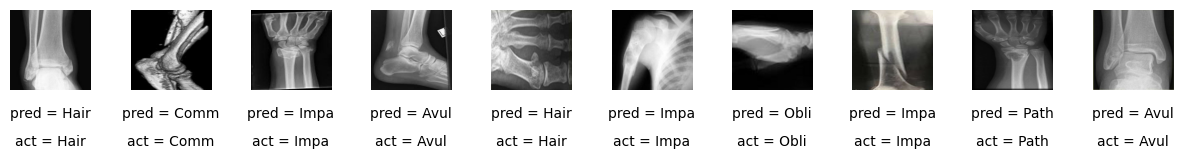

In [28]:
display_preds_act(n=10)

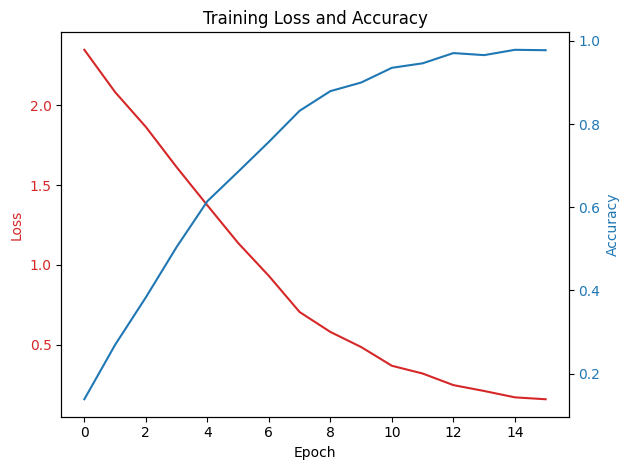

In [29]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


In [30]:
y_pred = final_xception.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.92      1.00      0.96        11
  Comminuted fracture       1.00      0.87      0.93        15
 Fracture Dislocation       0.85      1.00      0.92        17
  Greenstick fracture       0.91      1.00      0.95        10
    Hairline Fracture       0.91      1.00      0.95        10
    Impacted fracture       1.00      0.88      0.93         8
Longitudinal fracture       1.00      0.92      0.96        12
     Oblique fracture       1.00      0.90      0.95        10
Pathological fracture       1.00      0.92      0.96        12
      Spiral Fracture       1.00      1.00      1.00         7

             accuracy                           0.95       112
            macro avg       0.96      0.95      0.95       112
         weighted avg       0.95      0.95      0.95       112



In [31]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.91666667 1.         0.85       0.90909091 0.90909091 1.
 1.         1.         1.         1.        ]
Recall per class: [1.         0.86666667 1.         1.         1.         0.875
 0.91666667 0.9        0.91666667 1.        ]
F1 Score per class: [0.95652174 0.92857143 0.91891892 0.95238095 0.95238095 0.93333333
 0.95652174 0.94736842 0.95652174 1.        ]
Specificity per class: [0.9900990099009901, 1.0, 0.968421052631579, 0.9901960784313726, 0.9901960784313726, 1.0, 1.0, 1.0, 1.0, 1.0]
Cohen's Kappa Score: 0.9399892838006787
Matthews Correlation Coefficient (MCC): 0.9408309634059933


In [32]:
print(conf_matrix)

[[11  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  1  1  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  1  0  0  7  0  0  0  0]
 [ 1  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  0  0  0  0  9  0  0]
 [ 0  0  1  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  7]]


# Dense Net

In [35]:
from tensorflow.keras.applications import DenseNet201
densenet = DenseNet201(weights="imagenet", input_shape=(256, 256, 3), include_top=False, pooling=max)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [41]:
densenet = DenseNet201(weights="imagenet", input_shape=(256, 256, 3), include_top=False, pooling=max)

In [43]:
for layer in densenet.layers:
    layer.trainable = False

In [44]:
drop1 = Dropout(0.9)(densenet.output)
flat = Flatten() (drop1)
b1 = BatchNormalization(axis=-1)(flat)
dense1 = Dense(512, activation = 'sigmoid')(b1)
b2 = BatchNormalization(axis=-1)(dense1)
dense2 = Dense(512, activation = 'sigmoid')(b2)
b3 = BatchNormalization(axis=-1)(dense2)
dense3 = Dense(512, activation = 'relu')(b3)
drop2 = Dropout(0.9)(dense3)
output = Dense(10, activation = 'sigmoid')(drop2)

In [45]:
final_densenet = tf.keras.models.Model(inputs=[densenet.input], outputs=[output])

In [46]:
final_densenet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 262, 262,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 82,263,114 (313.81 MB)

 Trainable params: 63,693,322 (242.97 MB)

 Non-trainable params: 18,569,792 (70.84 MB)

In [48]:
final_densenet.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [51]:
history = final_densenet.fit(
    x_train,y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1266 - loss: 5.3017 
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.1554 - loss: 5.0986
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.2233 - loss: 4.1604
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.2771 - loss: 3.5285
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.2825 - loss: 3.4318
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.3490 - loss: 2.7540
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.3496 - loss: 2.7083
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.3899 - loss: 2.2028
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.4322 - loss: 2.3134
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.4932 - loss: 1.7928
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.4998 - loss: 1.8003
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step 

In [52]:
train_loss, train_accuracy = final_densenet.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_densenet.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 92.23%
Test Accuracy: 91.07%


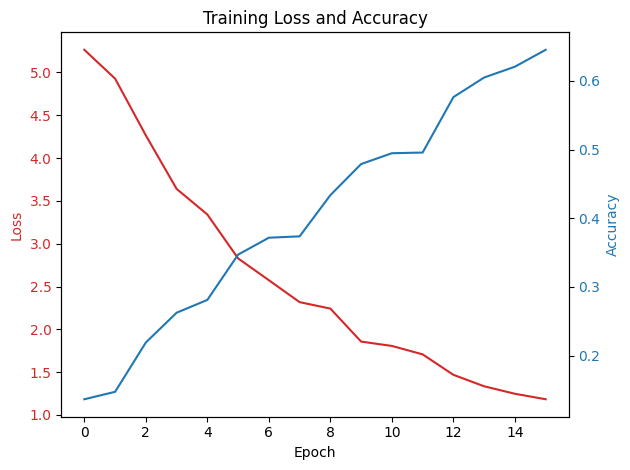

In [53]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


In [54]:
y_pred = final_densenet.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step 
                       precision    recall  f1-score   support

    Avulsion fracture       0.92      1.00      0.96        11
  Comminuted fracture       0.79      1.00      0.88        15
 Fracture Dislocation       0.94      1.00      0.97        17
  Greenstick fracture       1.00      0.90      0.95        10
    Hairline Fracture       1.00      0.80      0.89        10
    Impacted fracture       1.00      1.00      1.00         8
Longitudinal fracture       0.77      0.83      0.80        12
     Oblique fracture       1.00      0.70      0.82        10
Pathological fracture       1.00      0.83      0.91        12
      Spiral Fracture       0.88      1.00      0.93         7

             accuracy                           0.91       112
            macro avg       0.93      0.91      0.91       112
         weighted avg       0.92      0.91      0.91       112



In [55]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.91666667 0.78947368 0.94444444 1.         1.         1.
 0.76923077 1.         1.         0.875     ]
Recall per class: [1.         1.         1.         0.9        0.8        1.
 0.83333333 0.7        0.83333333 1.        ]
F1 Score per class: [0.95652174 0.88235294 0.97142857 0.94736842 0.88888889 1.
 0.8        0.82352941 0.90909091 0.93333333]
Specificity per class: [0.9900990099009901, 0.9587628865979382, 0.9894736842105263, 1.0, 1.0, 1.0, 0.97, 1.0, 1.0, 0.9904761904761905]
Cohen's Kappa Score: 0.899865891819401
Matthews Correlation Coefficient (MCC): 0.9014034750065767


In [56]:
print(conf_matrix)

[[11  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  1  0  0  0]
 [ 0  1  0  0  8  0  1  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  1  1  0  0  0 10  0  0  0]
 [ 1  2  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  1  0 10  1]
 [ 0  0  0  0  0  0  0  0  0  7]]
